# Extraction harmonique puis projection sur les modes verticaux

## Import

In [1]:
%load_ext memory_profiler
#%matplotlib widget
import matplotlib as mpl
from matplotlib import pyplot as plt
#from glob import glob
from pathlib import Path
import os

import numpy as np

import scipy.interpolate as itp
import xarray as xr
from xorca.lib import load_xorca_dataset
#import gsw
from xgcm import Grid

if True:
    from nemodez import Vmodes, load_vmodes

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client

Client Scheduler: tcp://127.0.0.1:60457 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 5.59 GiB


## Path and files

In [3]:
data_path = Path("/Volumes/Calcul/eNATL60")

data_fname = "eNATL60NOE-BLBT02_y2010m01d01.1h_*_0-botm.nc"
grid_fname = ["mesh_*_eNATL60NOE_3.6.nc", "mask_eNATL60NOE_3.6.nc"]

data_files = list(data_path.glob(data_fname))
grid_files = sum([list(data_path.glob(fna)) for fna in grid_fname],[]) # trick to flatten: sum([list_of_list],[])

## Loading data

In [4]:
### Loading data from numerical run
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

ds_tot = ds_tot.isel(t=0)
ds_tot

dataset is 2.6 GB


<xarray.Dataset>
Dimensions:   (x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    vomecrty  (z_c, y_r, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vosaline  (z_c, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    votemper  (z_c, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vovecrtz  (z_l, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vozocrtx  (z_c, y_c, x_r) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>

In [5]:
### Loading mean stratification profile
mean_file = data_path/"eNATL60NOE_mean_strat.nc"
ds_moy = xr.open_dataset(mean_file)
if "e3w" not in ds_moy:   
    ds_moy = ds_moy.assign_coords(e3w=ds_tot.e3w)
ds_moy

<xarray.Dataset>
Dimensions:   (x_c: 119, y_c: 137, z_c: 300, z_l: 300)
Coordinates: (12/13)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 130 131 132 133 134 135 136 137
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 112 113 114 115 116 117 118 119
    depth_c   (z_c) float64 ...
    llat_cc   (y_c, x_c) float32 ...
    llon_cc   (y_c, x_c) float32 ...
    ...        ...
    e2t       (y_c, x_c) float64 ...
    e3t       (z_c, y_c, x_c) float64 ...
    tmask     (z_c, y_c, x_c) int8 ...
    depth_l   (z_l) float64 ...
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
    e3w       (z_l, y_c, x_c) float64 ...
Data variables:
    vosaline  (z_c, y_c, x_c) float32 ...
    votemper  (z_c, y_c, x_c) float32 ...
    Nsqr      (z_l, y_c, x_c) float32 ...

## Extraction harmonique

bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.1 1.5
bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.0 1.5
bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.1 1.5


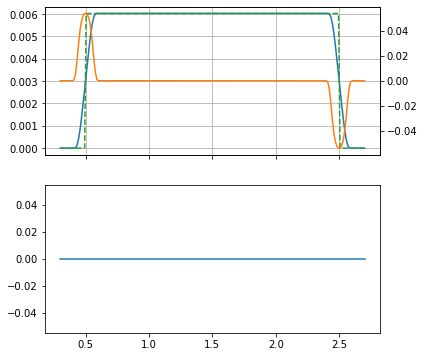

In [6]:
### define a window function

def planck_taper_ext(t, T=1., eps=.1, t0=0., normalized=True):
    """ planck taper window with transient centered at window length 
    quick and dirty implementation. Window is  centered
    planck taper with standard definition: transient centered at -T(.5-eps), T*(.5-eps). 
    extending time to T/(1-eps) make the interval between transient center equals T.
    return normalized window such that sum is 1 """
    print("bornes, T, eps, t0:", t.min(), t.max(), T, eps, t0)
    if eps>=.5:
        raise ValueError("need eps<.5. Passed value is {:.2f}".format(eps))
    t = (t-t0)/T*(1.-eps) # use coordinate mapping: stretching 
    t1, t4 = -.5, .5
    win = np.where((t>t1) * (t<t4), 1., 0.)
    if eps > 0.:
        t2 = (eps-.5)
        t3 = (.5-eps)
        z_t = np.where(t<0., (t2-t1)/(t-t1) + (t2-t1)/(t-t2), (t3-t4)/(t-t3) + (t3-t4)/(t-t4))
        win = np.where((t<t2) + (t>t3), win/(np.exp(z_t)+1.), win)

    if normalized and win.max()>0.:
        win /= win.sum()
        
    return win

### test it
Lwin, eps, t0 = 2., .1, 1.5
t_t = t0 + np.linspace(-Lwin*(.5+eps), Lwin*(.5+eps),200)
yy = planck_taper_ext(t_t, Lwin, eps, t0)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,6))
ax = axs[0]
ax.plot(t_t, yy)
ax.plot(t_t, planck_taper_ext(t_t, Lwin, 0., t0), linestyle="--", color="C2")
ax.grid(True)
bx = ax.twinx()
bx.plot(t_t, np.gradient(yy, t_t), color="C1")

ax = axs[1] # this must be 0
yy = planck_taper_ext(t_t, Lwin, eps, t0, normalized=False)
ax.plot(t_t, (yy>.5)-np.where( (t_t>t0-Lwin/2.) * (t_t<t0+Lwin/2.), 1., 0.) )

In [7]:
# """ HARMONIC EXTRACTION """
### Préparation dataset
da = xr.DataArray(data = ds_moy.isel(x_c=0, y_c=0, mode=0, missing_dims="ignore").Nsqr, dims = ("z_l"), coords = {"z_l" : ds_moy.isel(x_c=0, y_c=0, mode=0, missing_dims="ignore").z_l})
da

<xarray.DataArray 'Nsqr' (z_l: 300)>
array([           nan, 3.51942981e-05, 2.12614468e-05, 1.03999209e-05,
       6.35778770e-06, 4.28573276e-06, 3.08408880e-06, 2.33777109e-06,
       1.80376799e-06, 1.46018931e-06, 1.20413574e-06, 1.03855496e-06,
       8.99909821e-07, 8.10716926e-07, 7.46537069e-07, 7.38634185e-07,
       7.69215603e-07, 7.83504959e-07, 7.93066647e-07, 7.99996997e-07,
       8.17747775e-07, 8.34723096e-07, 9.16249746e-07, 1.09344614e-06,
       1.33274852e-06, 1.65599681e-06, 2.26963493e-06, 4.01270836e-06,
       8.48737636e-06, 1.94345903e-05, 4.18362288e-05, 7.57123416e-05,
       1.07954183e-04, 1.04202278e-04, 8.80259904e-05, 8.16421161e-05,
       6.96853895e-05, 5.85917005e-05, 4.93377120e-05, 4.32650413e-05,
       3.80647070e-05, 3.37972524e-05, 3.01865148e-05, 2.74139184e-05,
       2.52206592e-05, 2.34595373e-05, 2.20723850e-05, 2.09399823e-05,
       1.99968144e-05, 1.92375210e-05, 1.86411362e-05, 1.81986125e-05,
       1.78412465e-05, 1.75223522e-05, 1.72669224e-05, 1.70580824e-05,
       1.69170944e-05, 1.68167608e-05, 1.67558046e-05, 1.66958816e-05,
       1.65334968e-05, 1.63142649e-05, 1.61686203e-05, 1.60932559e-05,
       1.59887113e-05, 1.59794308e-05, 1.60268519e-05, 1.56606202e-05,
       1.53610144e-05, 1.51824997e-05, 1.49934413e-05, 1.48353984e-05,
       1.46902257e-05, 1.47583842e-05, 1.47607625e-05, 1.46429320e-05,
       1.50745363e-05, 1.47958217e-05, 1.54784830e-05, 1.54665431e-05,
...
       3.82925720e-07, 3.41699035e-07, 3.19434832e-07, 3.01821416e-07,
       2.95104172e-07, 2.87800731e-07, 2.90987288e-07, 3.04102258e-07,
       3.25486241e-07, 3.48204736e-07, 3.69804042e-07, 3.78672354e-07,
       3.60635084e-07, 3.45463803e-07, 3.59882335e-07, 3.59273230e-07,
       3.14945197e-07, 2.95000547e-07, 2.77183375e-07, 2.75132663e-07,
       2.84549657e-07, 2.87556304e-07, 2.75514850e-07, 2.67140166e-07,
       2.55786034e-07, 2.54612388e-07, 2.47315171e-07, 2.46716780e-07,
       2.35058735e-07, 2.20379405e-07, 2.04441875e-07, 1.99624850e-07,
       2.07536246e-07, 2.18723599e-07, 1.28592987e-07, 1.66935706e-07,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan],
      dtype=float32)
Coordinates:
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5

l : 2
bornes, T, eps, t0: <xarray.DataArray 'Nsqr' ()>
array(3.5194298e-05, dtype=float32) <xarray.DataArray 'Nsqr' ()>
array(3.5194298e-05, dtype=float32) 1.5707963267948966 0.4 <xarray.DataArray 'z_l' ()>
array(1.)


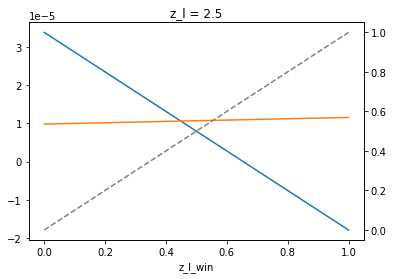

In [20]:
### Define periods and stuff
dz = 1
omega = 4
f = omega / 2./np.pi
eps_win = .4# relative length (in periods) of transient for time window
n_per = 1 # number of targeted periods / window
n_win = int(round( ((n_per+eps_win))/f/dz))
print("l :", n_win)

### harmonic extraction
# create rolling object and construt: window index is a new dim, "t_win"
da_rol = (da*xr.ufuncs.exp(-1.j*omega*da.z_l)).rolling(z_l=n_win, center=True).construct("z_l_win")
win = xr.DataArray(data=planck_taper_ext(da[:n_win], T=n_per/f, eps=eps_win, t0=da.z_l[:n_win].mean()), 
                   dims=("z_l_win"))
da_harmo_win = (da_rol*win).sum("z_l_win")

da_rol.isel(z_l=n_win).real.plot()
da_rol.isel(z_l=n_win).imag.plot()
bx = plt.gca().twinx()
win.plot(ax=bx, linestyle="--", color="grey")

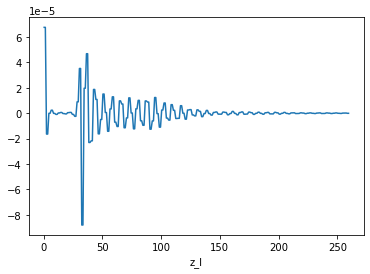

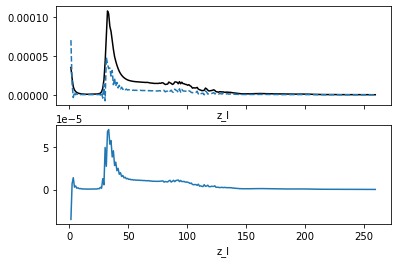

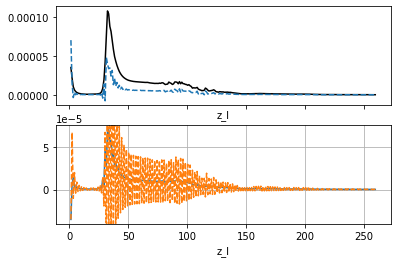

In [21]:
"""
Méthodes reconstruction:
    Méthode 1:
        Pour chaque fenêtre on multiplie la valeur par exp(j*omega*t) avec t vecteur temps réduit à la fenêtre
    Méthode 2:
        Interpolation linéaire entre chaque point 
        Rééchantillonage au temps de tps
        Multiplication en chaque point par exp(j*omega*t)
"""

# take harmonic with no windowing
da_harmo = (2*da*xr.ufuncs.exp(-1.j*omega*da.z_l)).coarsen(
                        z_l=n_win, boundary="trim", side="left").mean()

### Méthode 1
# une façon de procéder est d'utiliser interp1d avec method=nearest (un peu moche car commence par étendre le tableau des coefficient complexes)
# une autre façon est d'utiliser un groupby_bins sur le tableau de exp(1.j*omega*time). Pas fait ici
plt.figure()
da_harmo.interp(z_l=da.z_l, method="nearest", kwargs={"fill_value":"extrapolate"}).real.plot()

fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
da.plot(ax=ax, color="k")
reco = (da_harmo.interp(z_l=da.z_l, method="nearest")*xr.ufuncs.exp(1.j*omega*da.z_l)).real
reco.plot(ax=ax, linestyle="--")
ax = axs[1]
(da-reco).plot(ax=ax)

# method 2: interp
fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
da.plot(ax=ax, color="k")
reco = (da_harmo.interp(z_l=da.z_l, method="nearest")*xr.ufuncs.exp(1.j*omega*da.z_l)).real
reco.plot(ax=ax, linestyle="--")
ax = axs[1]
(da-reco).plot(ax=ax)

# also using harmonic extraction with windowing // emulate coarsening and re-interp
# it is a bit better except at the boundaries 
# (because I did not use a special treatment at boundaries, but this can be fixed easily)
limy = ax.get_ylim()
reci = (2*da_harmo_win.isel(z_l=slice(n_win//2,None,n_win)).interp(z_l=da.z_l, method="nearest")*xr.ufuncs.exp(1.j*omega*da.z_l)).real
(da-reci).plot(ax=ax, linestyle="--")
ax.set_ylim(limy)
ax.grid(True)

In [29]:
reci.data

array([            nan,  7.03885962e-05, -4.60090569e-05,  2.07998419e-05,
       -1.35956840e-05,  8.57146551e-06, -5.60268375e-06,  4.67554219e-06,
       -3.05613832e-06,  2.92037862e-06, -1.90888686e-06,  2.07710991e-06,
       -1.35768964e-06,  1.62143385e-06, -1.05983989e-06,  1.47726837e-06,
       -9.65607046e-07,  1.56700992e-06, -1.02426604e-06,  1.59999399e-06,
       -1.04582587e-06,  1.66944619e-06, -1.09122285e-06,  2.18689229e-06,
       -1.42944819e-06,  3.31199362e-06, -2.16486350e-06,  8.02541672e-06,
       -5.24576244e-06,  3.88691806e-05, -2.54065919e-05,  1.51424683e-04,
       -9.89777783e-05,  2.08404555e-04, -1.36222308e-04,  1.63284232e-04,
       -1.06729697e-04,  1.17183401e-04, -7.65961825e-05,  8.65300826e-05,
       -5.65598365e-05,  6.75945048e-05, -4.41827169e-05,  5.48278367e-05,
       -3.58378657e-05,  4.69190745e-05, -3.06683538e-05,  4.18799646e-05,
       -2.73745717e-05,  3.84750419e-05, -2.51489657e-05,  3.63972249e-05,
       -2.37908139e-05,  

In [45]:
Nsqr = reci.data
reci_ok = xr.DataArray(data = Nsqr ,dims = ("z_l"), coords = {"z_l" : ds_moy.isel(x_c=0, y_c=0, mode=0, missing_dims="ignore").z_l})
reci_ok

<xarray.DataArray (z_l: 300)>
array([            nan,  7.03885962e-05, -4.60090569e-05,  2.07998419e-05,
       -1.35956840e-05,  8.57146551e-06, -5.60268375e-06,  4.67554219e-06,
       -3.05613832e-06,  2.92037862e-06, -1.90888686e-06,  2.07710991e-06,
       -1.35768964e-06,  1.62143385e-06, -1.05983989e-06,  1.47726837e-06,
       -9.65607046e-07,  1.56700992e-06, -1.02426604e-06,  1.59999399e-06,
       -1.04582587e-06,  1.66944619e-06, -1.09122285e-06,  2.18689229e-06,
       -1.42944819e-06,  3.31199362e-06, -2.16486350e-06,  8.02541672e-06,
       -5.24576244e-06,  3.88691806e-05, -2.54065919e-05,  1.51424683e-04,
       -9.89777783e-05,  2.08404555e-04, -1.36222308e-04,  1.63284232e-04,
       -1.06729697e-04,  1.17183401e-04, -7.65961825e-05,  8.65300826e-05,
       -5.65598365e-05,  6.75945048e-05, -4.41827169e-05,  5.48278367e-05,
       -3.58378657e-05,  4.69190745e-05, -3.06683538e-05,  4.18799646e-05,
       -2.73745717e-05,  3.84750419e-05, -2.51489657e-05,  3.63972249e-05,
       -2.37908139e-05,  3.50447044e-05, -2.29067475e-05,  3.41161649e-05,
       -2.22998136e-05,  3.36335215e-05, -2.19843368e-05,  3.33917633e-05,
       -2.18263131e-05,  3.26285299e-05, -2.13274304e-05,  3.21865118e-05,
       -2.10385081e-05,  3.19588617e-05, -2.08897061e-05,  3.13212404e-05,
       -2.04729290e-05,  3.03649995e-05, -1.98478882e-05,  2.96707967e-05,
       -1.93941270e-05,  2.95167683e-05, -1.92934473e-05,  2.92858640e-05,
       -1.91425182e-05,  2.95916434e-05, -1.93423889e-05,  3.09330862e-05,
...
       -5.22284600e-07,  7.78610854e-07, -5.08934018e-07,  7.72797875e-07,
       -5.05134402e-07,  6.83398071e-07, -4.46698789e-07,  6.03642832e-07,
       -3.94567286e-07,  5.75601462e-07, -3.76238224e-07,  6.08204516e-07,
       -3.97549002e-07,  6.96409472e-07, -4.55203609e-07,  7.57344708e-07,
       -4.95033537e-07,  6.90927607e-07, -4.51620423e-07,  7.18546460e-07,
       -4.69673310e-07,  5.90001093e-07, -3.85650451e-07,  5.50265327e-07,
       -3.59677421e-07,  5.75112608e-07, -3.75918688e-07,  5.34280332e-07,
       -3.49228931e-07,  5.09224776e-07, -3.32851526e-07,  4.93433561e-07,
       -3.22529699e-07,  4.40758811e-07, -2.88099185e-07,  3.99249700e-07,
       -2.60967020e-07,  4.37447198e-07, -2.85934571e-07,  3.33871412e-07,
       -2.18232919e-07, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
Coordinates:
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5

## Calcul des modes verticaux

In [49]:
### Define xgcm grids
# WARNINGS: for vertical level: weights only for T-lev on T, u and v grid, and for w-lev on T_points
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    #('X', 'Y'): [] # Areas TODO
}
ix, jy = slice(0,1), slice(0, 1)
sds = ds_tot.isel(x_c=ix, x_r=ix, y_c=jy, y_r=jy).chunk({"x_c":10, "y_c":10})
#sdm = ds_moy.isel(x_c=ix, y_c=jy).chunk({"x_c":10, "y_c":10, "z_c":-1, "z_l":-1})
sdm = reci.chunk({"z_l":-1})
grid = Grid(sds, metrics=metrics, periodic=False)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_r --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_r --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center

In [50]:
sdm

<xarray.DataArray (z_l: 300)>
dask.array<xarray-<this-array>, shape=(300,), dtype=float64, chunksize=(300,), chunktype=numpy.ndarray>
Coordinates:
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5

In [47]:
vmods = Vmodes(sdm, grid, nmodes=10, free_surf=False, persist=True)
dm = vmods.ds
dm

KeyError: 'Nsqr'

In [25]:
### store modes and reload it
vmods.store("essai_2.zarr", mode="w")
del vmods
vmods = load_vmodes("essai_2.zarr")
vmods

NameError: name 'vmods' is not defined

In [26]:
plt.figure()
dm.c.plot(marker="*", yscale="log")
plt.grid(True)

NameError: name 'dm' is not defined

<Figure size 432x288 with 0 Axes>

In [27]:
### check orthonormality
dm = dm.isel(x_c=0, y_c=0, mode=slice(10), missing_dims="ignore")

pnpm = (dm.phi*dm.phi.rename({"mode":"modm"})*dm.e3t).sum("z_c") / dm.norm.mean()
wnwm = dm.phiw/dm.c * (dm.phiw/dm.c).rename({"mode":"modm"})
wnwm_b = ( (wnwm*dm.Nsqr*dm.e3w).sum("z_l") + vmods.g*wnwm.isel(z_l=0) ) / dm.norm.mean()
wnwm_a = ( (grid.interp(wnwm*dm.Nsqr, "Z", boundary="fill", fill_value=0) * dm.e3t).sum("z_c") 
        + vmods.g * wnwm.isel(z_l=0) )/dm.norm.mean()

norm = mpl.colors.LogNorm(vmin=1e-6, vmax=1e0)
fig, axs = plt.subplots(1, 3, figsize=(8,2))
ax = axs[0]
hpc = ax.imshow(pnpm.values, norm=norm)
plt.colorbar(hpc, ax=ax)
ax = axs[1]
hpc = ax.imshow(wnwm_a.values, norm=norm)
plt.colorbar(hpc, ax=ax)
ax = axs[2]
hpc = ax.imshow(wnwm_b.values, norm=norm)
plt.colorbar(hpc, ax=ax)

NameError: name 'dm' is not defined

In [28]:
imod = -1

plt.figure()
dm.phiw.isel(mode=imod).plot(y="depth_l", marker=".")

I = (grid.interp(dm.phiw.isel(mode=imod)**2*dm.Nsqr, "Z", boundary="fill", fill_value=0) * dm.e3t).sum("z_c")
S = vmods.g*dm.phiw.isel(z_l=0,mode=imod)**2
res = (dm.c**2*dm.norm).isel(mode=imod)
I.values, S.values, res.values

NameError: name 'dm' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
modamp = vmods.project_w(sds.vovecrtz)

plt.figure()
sds.vovecrtz.isel(x_c=0, y_c=0).plot(y="depth_l", marker="+")
vmods.reconstruct_w(modamp).assign_coords(depth_l=sds.depth_l).isel(x_c=0, y_c=0).plot(y="depth_l", linestyle="--")
plt.grid(True)